In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import numpy as np
import warnings
import os
import sys

sys.path.append(os.path.abspath('..'))
warnings.simplefilter(action='ignore', category=FutureWarning)

# Caricamento del dataset
filename = '../data/temp/00_training_data_cleaned.csv'
try:
    df_clean = pd.read_csv(filename)
    print("Dataset caricato correttamente.")
except FileNotFoundError:
    print(f"Errore: il file '{filename}' non è stato trovato.")  

Dataset caricato correttamente.


### **Segmentazione Fasi di Volo**

In questa fase si cerca di determinare quantitativamente se le fasi stazionarie contengono informazione utile relativa al degrado del motore, o se la loro variabilità è trascurabile rispetto alle fasi dinamiche, risultando quindi in semplice rumore.
Dopo aver pulito il dataset, si potranno individuare le fasi di volo: **Taxi-Out, Takeoff, Cruise, Climb, Descent, Landing e Taxi-In**.

Per individuare in quale fase si trova ogni snapshot, lo script implementa un **approccio deterministico e basato sulla fisica del volo**, calcolando nuove metriche fondamentali per capire il contesto di volo:

- **Rateo di Salita/Discesa (`Alt_Delta`)**: calcola la differenza di altitudine rispetto allo snapshot precedente.

- **Trend Futuro (`Alt_Delta_Next`)**: guarda in avanti di uno snapshot (lookahead). Cruciale per la fase di decollo, per capire se l'aereo sta iniziando a salire bruscamente prima ancora che l'altitudine sia diventata alta.

- **Progresso del Volo (`Flight_Progress`)**: normalizza il tempo di volo tra 0 e 1, per disambiguare fasi simili che avvengono a terra. Se siamo a terra e velocità bassa all'inizio (0-0.3) è Taxi-Out; se siamo alla fine (0.7-1.0) è Taxi-In.

- **Altitudine Dinamica (`Alt_Ground`)**: calcola l'altitudine minima per ogni specifico volo, poiché un aeroporto può essere sul mare (0 ft) o in montagna (5000 ft). Il codice definisce "Terra" come `Alt_Ground + 2000 ft`, rendendo l'algoritmo adattivo a qualsiasi aeroporto.

La **priorità** in questa pipeline è fondamentale: le condizioni più specifiche vengono testate prima di quelle generiche.

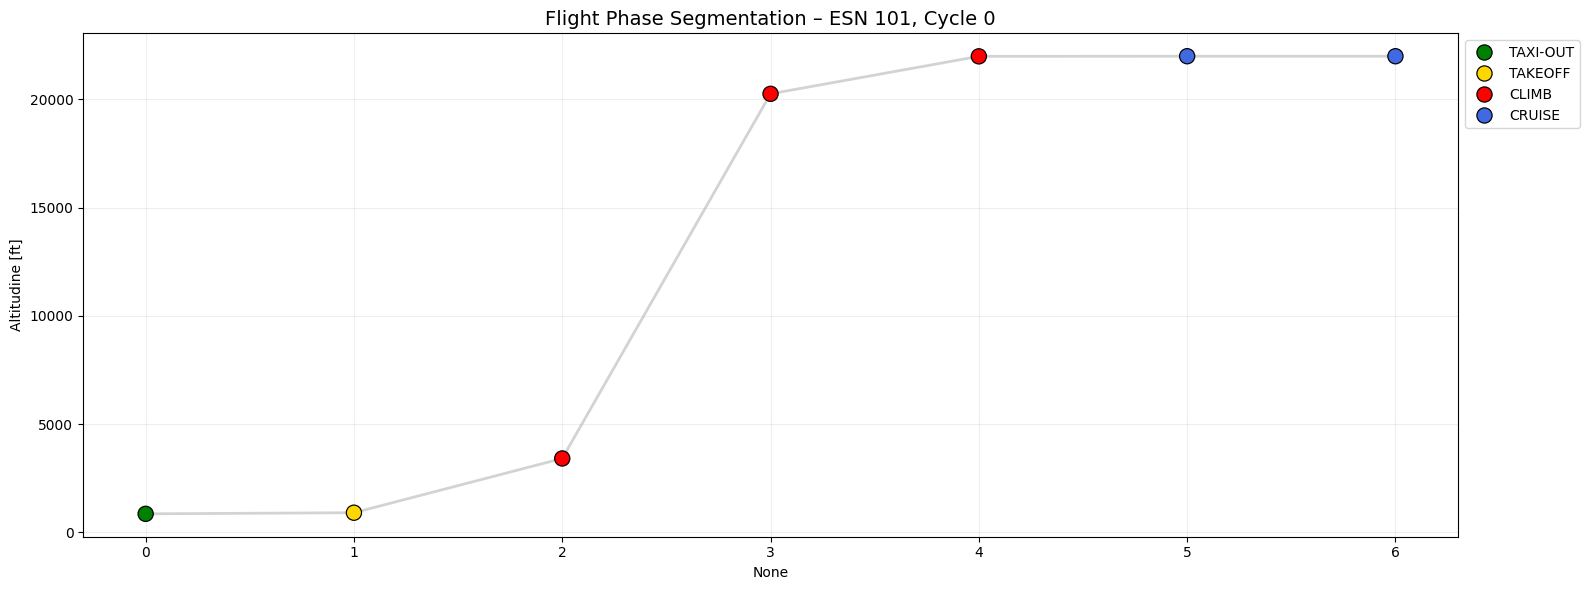

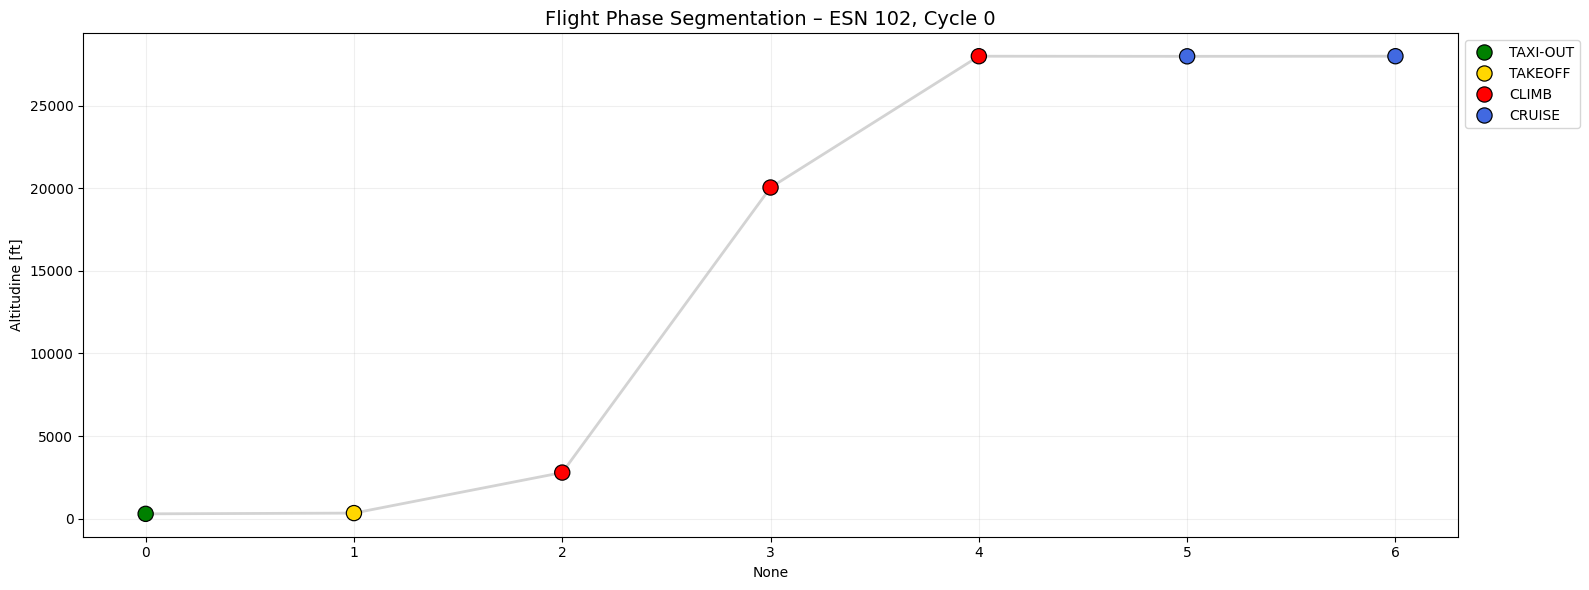

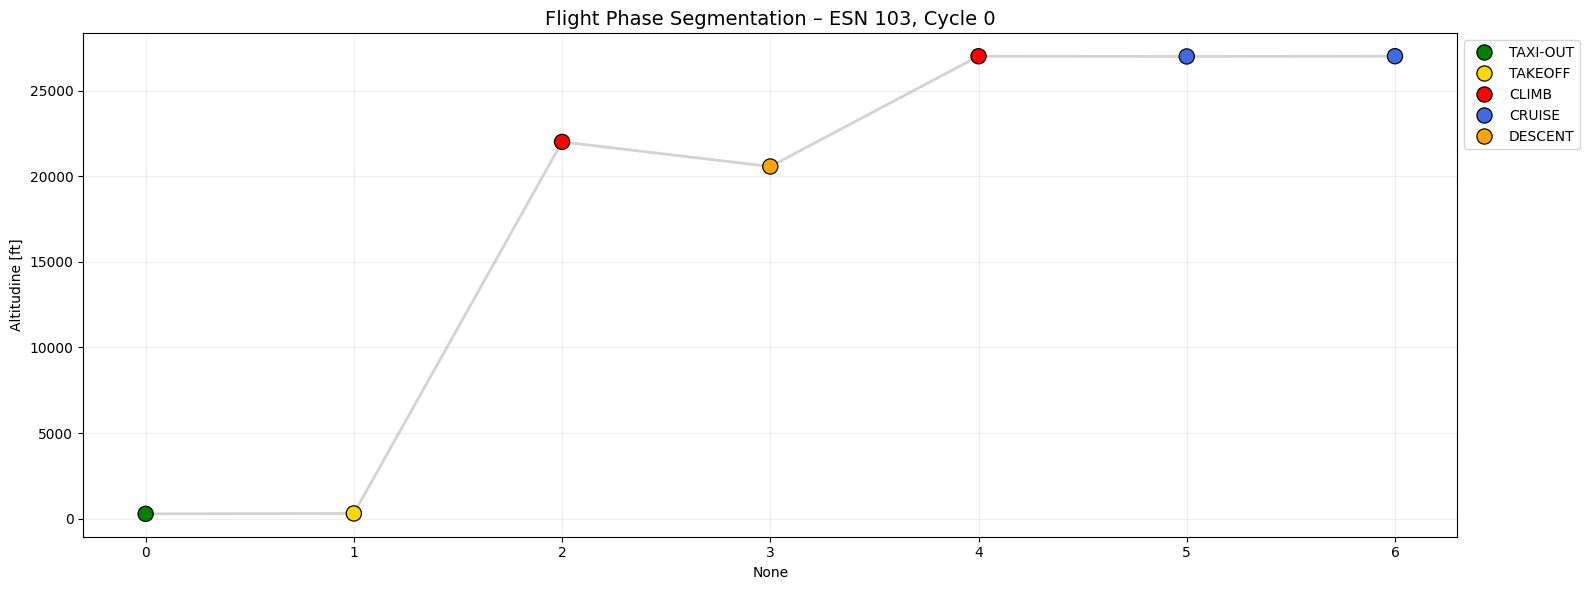

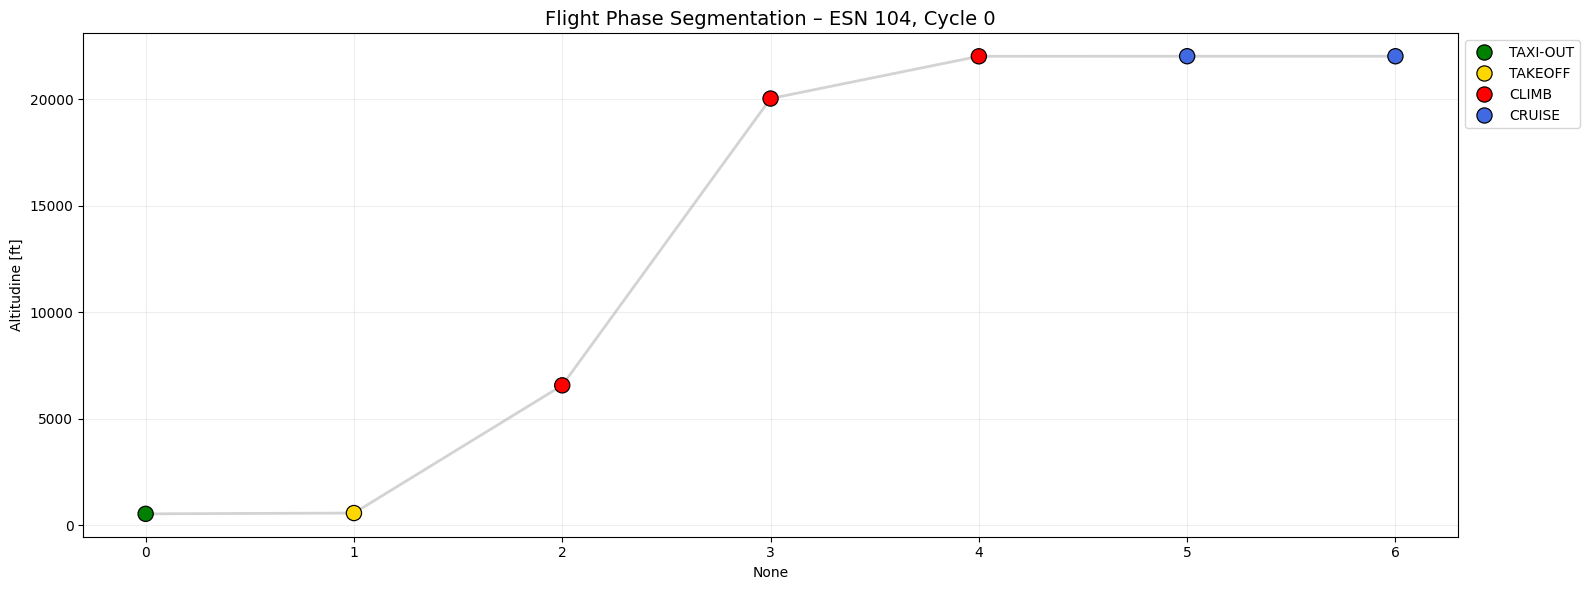

In [2]:
def segment_flight_phases(df):
    """
    Flight phase segmentation.
    Usa soglie dinamiche per ogni volo: altitudine a terra stimata e ratei relativi.
    """
    df_out = df.copy()

    # =============================
    # 1. FEATURE ENGINEERING
    # =============================

    # A. Delta di Altitudine (Current - Previous)
    df_out['Alt_Delta'] = df_out.groupby(['ESN', 'Cycles_Since_New'])['Sensed_Altitude'].diff().fillna(0)

    # B. Delta Altitude Next (Lookahead per capire trend futuro)
    df_out['Alt_Delta_Next'] = (
        df_out.groupby(['ESN', 'Cycles_Since_New'])['Sensed_Altitude'].shift(-1)
        - df_out['Sensed_Altitude']
    ).fillna(0)

    # C. Flight Progress (0 → 1)
    max_snap = df_out.groupby(['ESN', 'Cycles_Since_New'])['Snapshot'].transform('max')
    min_snap = df_out.groupby(['ESN', 'Cycles_Since_New'])['Snapshot'].transform('min')
    denom   = max_snap - min_snap
    df_out['Flight_Progress'] = np.where(
        denom == 0, 0.5,
        (df_out['Snapshot'] - min_snap) / denom
    )

    # D. Altitudine di riferimento AEROPORTO dinamica
    df_out['Alt_Ground'] = df_out.groupby(['ESN', 'Cycles_Since_New'])['Sensed_Altitude'].transform('min')

    # threshold per distinguere terra / volo
    df_out['Ground_Threshold'] = df_out['Alt_Ground'] + 2000  # 2000 ft sopra l’aeroporto

    # =============================
    # 2. SOGLIE DINAMICHE
    # =============================

    THRESH_MACH_MOVE = 0.15       # sotto ~0.15 ≈ taxi
    THRESH_RATE_CLIMB = 500       # salita/discesa significativa
    THRESH_RATE_DESC  = -500

    # =============================
    # 3. CONDIZIONI (ordine fondamentale)
    # =============================

    conditions = [
        # --------------------
        # A. GROUND OPERATIONS
        # --------------------
        # TAXI-OUT → inizio volo
        (df_out['Sensed_Altitude'] < df_out['Ground_Threshold']) &
        (df_out['Sensed_Mach'] < THRESH_MACH_MOVE) &
        (df_out['Flight_Progress'] < 0.3),

        # TAXI-IN → fine volo
        (df_out['Sensed_Altitude'] < df_out['Ground_Threshold']) &
        (df_out['Sensed_Mach'] < THRESH_MACH_MOVE) &
        (df_out['Flight_Progress'] > 0.7),

        # --------------------
        # B. TAKEOFF / LANDING
        # --------------------
        # TAKEOFF: dalla zona di terra, inizia a salire velocemente
        (df_out['Sensed_Altitude'] < df_out['Ground_Threshold']) &
        ((df_out['Alt_Delta'] > THRESH_RATE_CLIMB) | (df_out['Alt_Delta_Next'] > THRESH_RATE_CLIMB)) &
        (df_out['Flight_Progress'] < 0.4),

        # LANDING: rientra sotto la ground-threshold con rateo marcato
        (df_out['Sensed_Altitude'] < df_out['Ground_Threshold']) &
        ((df_out['Alt_Delta'] < THRESH_RATE_DESC)) &
        (df_out['Flight_Progress'] > 0.6),

        # --------------------
        # C. SALITA E DISCESA
        # --------------------
        (df_out['Alt_Delta'] > THRESH_RATE_CLIMB),   # CLIMB

        (df_out['Alt_Delta'] < THRESH_RATE_DESC),    # DESCENT

        # --------------------
        # D. CROCIERA
        # --------------------
        (df_out['Sensed_Altitude'] >= df_out['Ground_Threshold']) &
        (df_out['Alt_Delta'].abs() <= 500)
    ]

    choices = [
        'TAXI-OUT',
        'TAXI-IN',
        'TAKEOFF',
        'LANDING',
        'CLIMB',
        'DESCENT',
        'CRUISE'
    ]

    df_out['Flight_Phase'] = np.select(conditions, choices, default='CRUISE')

    return df_out


# =============================
# VISUALIZZAZIONE
# =============================
def visualize_segmentation(df, engine_id, cycle_start=0, cycle_count=1):
    subset = df[
        (df['ESN'] == engine_id) &
        (df['Cycles_Since_New'] >= cycle_start) &
        (df['Cycles_Since_New'] < cycle_start + cycle_count)
    ].copy().reset_index(drop=True)

    if subset.empty:
        return

    fig, ax = plt.subplots(figsize=(16, 6))

    # Profilo altimetrico
    sns.lineplot(
        data=subset, x=subset.index, y='Sensed_Altitude',
        color='lightgrey', linewidth=2, zorder=1, ax=ax
    )

    # Colori delle fasi
    phase_colors = {
        'TAXI-OUT': 'green',
        'TAKEOFF':  'gold',
        'CLIMB':    'red',
        'CRUISE':   'royalblue',
        'DESCENT':  'orange',
        'LANDING':  'purple',
        'TAXI-IN':  'brown'
    }

    sns.scatterplot(
        data=subset, x=subset.index, y='Sensed_Altitude',
        hue='Flight_Phase', palette=phase_colors,
        s=120, edgecolor='black', zorder=2, ax=ax
    )

    ax.set_title(f"Flight Phase Segmentation – ESN {engine_id}, Cycle {cycle_start}", fontsize=14)
    ax.set_ylabel("Altitudine [ft]")
    plt.grid(True, alpha=0.2)

    order = ['TAXI-OUT', 'TAKEOFF', 'CLIMB', 'CRUISE', 'DESCENT', 'LANDING', 'TAXI-IN']
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ordered_labels = [l for l in order if l in by_label]
    ordered_handles = [by_label[l] for l in ordered_labels]
    ax.legend(ordered_handles, ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# =============================
# ESECUZIONE
# =============================
df_segmented = segment_flight_phases(df_clean)

visualize_segmentation(df_segmented, engine_id=101, cycle_start=0, cycle_count=3)
visualize_segmentation(df_segmented, engine_id=102, cycle_start=0, cycle_count=6)
visualize_segmentation(df_segmented, engine_id=103, cycle_start=0, cycle_count=1)
visualize_segmentation(df_segmented, engine_id=104, cycle_start=0, cycle_count=1)


I grafici mostrano l'efficacia del metodo di segmentazione su tutti i motori del dataset di partenza, con alcuni dettagli che emergono dalla comparazione:

- **Coerenza generale (Motori 101, 102 e 104)**: il pattern di volo standard viene identificato correttamente. Le fasi "Taxi-Out" (verde) sono sempre a quote basse, e le fasi "Cruise" (blu) sono a quote elevate e stabili. La fase "Takeoff" (giallo) viene identificata correttamente a bassa quota, prevedendo uno step successivo molto più alto, ovvero la fase di "Climb" (rosso).

- **Sensibilità (Motore 103)**: il grafico mostra un'anomalia o discesa intermedia. Il punto 3, infatti, viene identificato come fase "Descent" (arancione): l'algoritmo ha rilevato correttamente che, anche se siamo a metà volo, c'è stata una perdita di quota significativa, classificandola come discesa momentanea prima di risalire (punto 4, rosso).

- **Mancanza delle fasi finali**: osservando i grafici si può dedurre che **non ci sono dati continui di tutto il volo**. Le fasi di "Landing" (atterraggio) e "Taxi-In" non compaiono mai, questo potrebbe essere una scelta a monte di una rimozione di dati apposita per sfidare i modelli di predizione. Si potrebbe anche ipotizzare che, spesso, in atterraggio e rullaggio finale il motore è spesso al minimo o in regime transitorio molto variabile. Questi dati sono sporchi e meno utili per calcolare l'usura del motore, quindi potrebbero non essere stati registrati a priori.

In conclusione, il metodo si rivela essere robusto e generalizza bene sui vari motori presenti nel dataset.

---

### **Analisi della Variabilità**

Il prossimo passo è quello **dell'analisi fine della variabilità**, al fine di calcolare la varianza dei sensori fisici del motore (temperature, pressioni, velocità) dentro le fasi specifiche.
Il seguente codice calcola una **Tabella di "Qualità del Segnale"**, calcolando per ogni sensore i seguenti rapporti:

$$\frac{\sigma_{Taxi}}{\sigma_{Climb}}$$
$$\frac{\sigma_{Cruise}}{\sigma_{Climb}}$$

- **Rapporto basso (<0.1)**: fase molto stabile, ottima per trovare trend lenti (degrado), pessima per dinamica.
- **Rapporto alto (>0.5)**: fase molto rumorosa o dinamica anche quando dovrebbe essere ferma.


--- CLASSIFICA VARIABILITÀ SENSORI (Taxi-Out vs Climb) ---
Ratio > 0.5: Sensore rumoroso a terra (probabile dinamica spuria)
Ratio < 0.1: Sensore molto stabile (ottimo per baseline)
------------------------------------------------------------
           Sensor  Sigma_TaxiOut  Sigma_Climb  Ratio_TaxiOut_Climb  Ratio_Cruise_Climb
       Sensed_VBV         0.6461       0.2054               3.1454              0.5647
        Sensed_T5       124.0369      84.9298               1.4605              0.7209
       Sensed_T25        45.4599      37.8161               1.2021              0.8176
 Sensed_Fan_Speed        63.8157      63.4406               1.0059              1.0955
      Sensed_VAFN       358.5747     371.4393               0.9654              0.5561
       Sensed_T45        98.1078     101.9440               0.9624              0.8159
        Sensed_T3        66.6856      75.9652               0.8778              0.7528
     Sensed_WFuel         0.2074       0.2524               

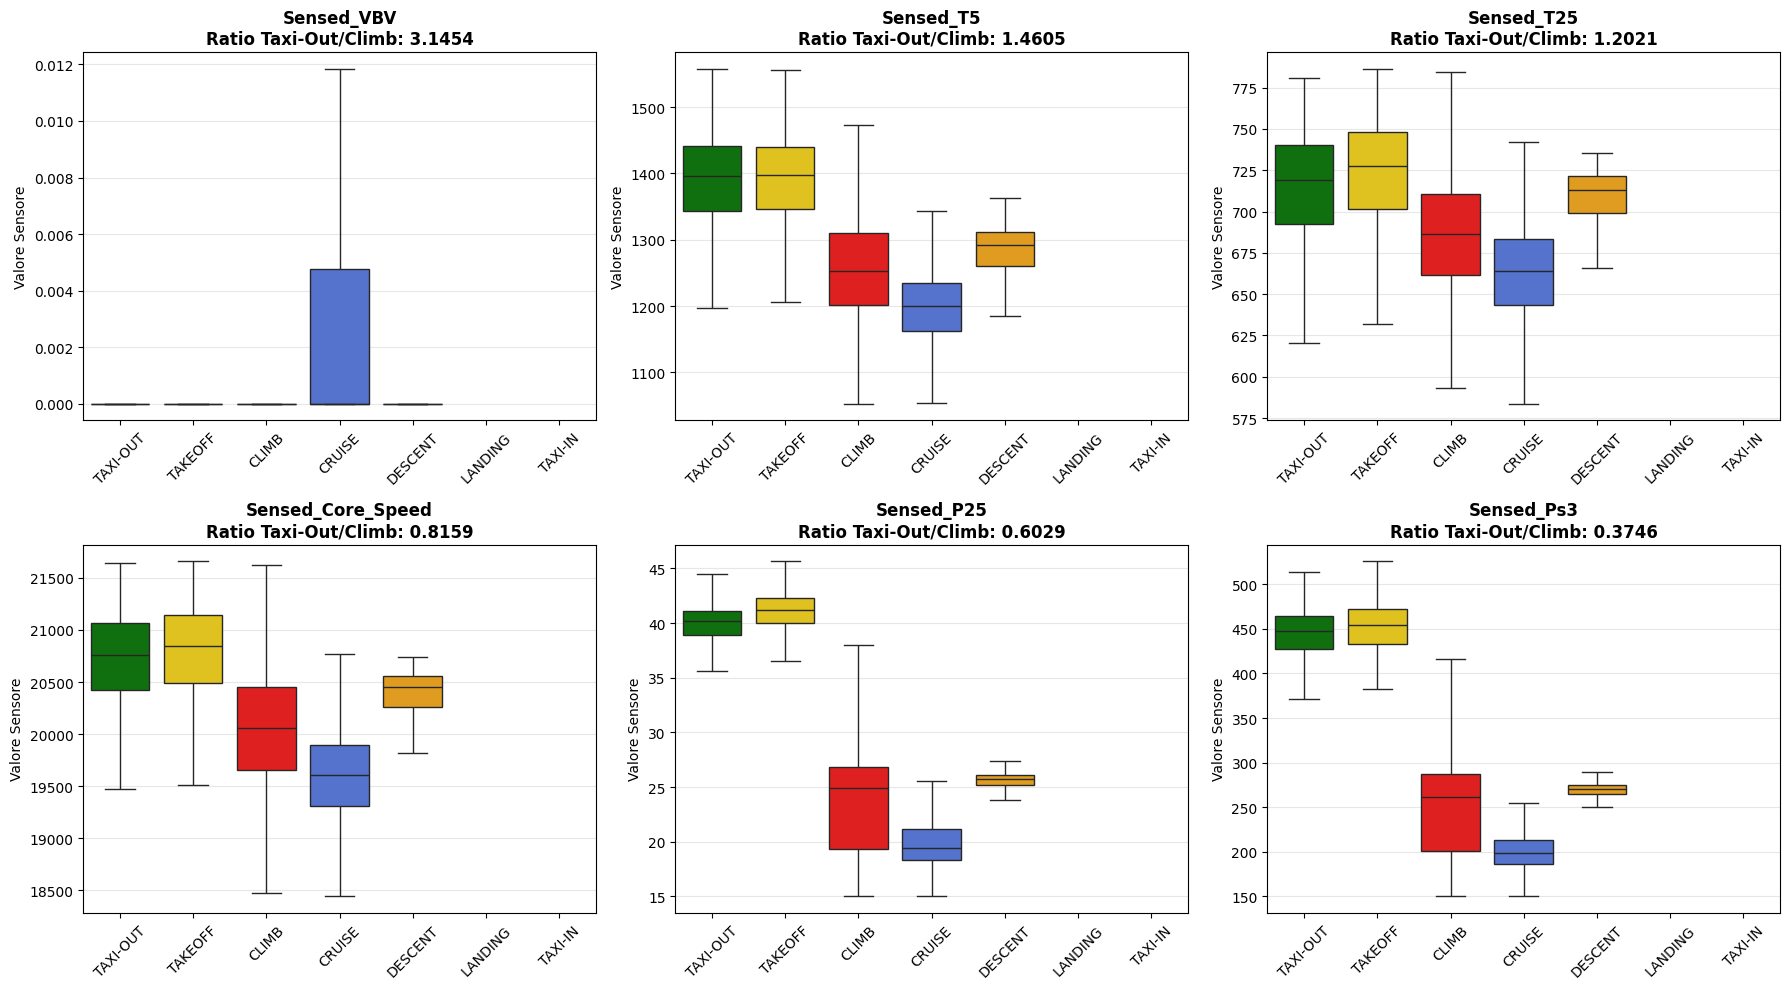

In [3]:
# Lista dei sensori utili
useful_sensors = [
    'Sensed_T25', 'Sensed_T3', 'Sensed_T45', 'Sensed_T5', 
    'Sensed_P25', 'Sensed_Ps3', 
    'Sensed_Fan_Speed', 'Sensed_Core_Speed', 
    'Sensed_WFuel', 'Sensed_VAFN', 'Sensed_VBV'
]

def analyze_sensors_variability(df, sensors_list):
    """
    Calcola il rapporto di variabilità tra fasi stazionarie (Taxi-Out/Cruise)
    e fasi dinamiche (Climb) per ogni sensore utile.
    """
    results = []
    
    for sensor in sensors_list:
        if sensor in df.columns:
            # Calcolo std dev per fase di volo
            std_by_phase = df.groupby('Flight_Phase')[sensor].std()
            
            # 1. Recupero Sigma per le fasi chiave presenti nei dati
            # Si usa 'TAXI-OUT' perché 'TAXI-IN' manca nei dati snapshot
            sigma_climb = std_by_phase.get('CLIMB', np.nan)
            sigma_taxi_out = std_by_phase.get('TAXI-OUT', 0.0) 
            sigma_cruise = std_by_phase.get('CRUISE', 0.0)
            
            # Gestione caso in cui Climb sia 0 o NaN
            if pd.isna(sigma_climb) or sigma_climb == 0:
                ratio_taxi = 0.0
                ratio_cruise = 0.0
            else:
                # 2. Calcolo dei Rapporti
                # Ratio TaxiOut = Quanto è rumoroso a terra rispetto alla salita?
                ratio_taxi = sigma_taxi_out / sigma_climb
                
                # Ratio Cruise = Quanto è rumoroso in crociera rispetto alla salita?
                ratio_cruise = sigma_cruise / sigma_climb
            
            results.append({
                'Sensor': sensor,
                'Sigma_Climb': sigma_climb,
                'Sigma_TaxiOut': sigma_taxi_out,
                'Ratio_TaxiOut_Climb': ratio_taxi,
                'Ratio_Cruise_Climb': ratio_cruise
            })
            
    # Si ordina per chi ha il rapporto Taxi/Climb più alto (i più rumorosi a terra)
    res_df = pd.DataFrame(results).sort_values(by='Ratio_TaxiOut_Climb', ascending=False)
    return res_df

def plot_top_variability_comparison(df, res_df, top_n=3):
    """
    Plotta i boxplot dei sensori, includendo tutte le fasi per contesto,
    ma evidenziando nel titolo il rapporto calcolato su TAXI-OUT.
    """
    # Seleziona i sensori più "rumorosi" e più "stabili" a terra
    if res_df.empty:
        print("Nessun dato di variabilità calcolato.")
        return

    high_var_sensors = res_df.head(top_n)['Sensor'].tolist()
    low_var_sensors = res_df.tail(top_n)['Sensor'].tolist()
    
    sensors_to_plot = high_var_sensors + low_var_sensors
    
    # Rimozione dei duplicati se la lista è corta
    sensors_to_plot = list(dict.fromkeys(sensors_to_plot))
    
    plt.figure(figsize=(18, 5 * ((len(sensors_to_plot) + 2) // 3)))
    
    # Si mantiene l'ordine completo per coerenza visiva, anche se Landing/Taxi-In saranno vuoti
    order = ['TAXI-OUT', 'TAKEOFF', 'CLIMB', 'CRUISE', 'DESCENT', 'LANDING', 'TAXI-IN']
    
    palette_colors = {
        'TAXI-OUT': 'green',
        'TAKEOFF':  'gold',
        'CLIMB':    'red',
        'CRUISE':   'royalblue',
        'DESCENT':  'orange',
        'LANDING':  'purple',
        'TAXI-IN':  'brown'
    }
    
    for i, sensor in enumerate(sensors_to_plot):
        plt.subplot(2, 3, i+1)
        
        sns.boxplot(
            x='Flight_Phase', 
            y=sensor, 
            data=df, 
            order=order, 
            palette=palette_colors,
            showfliers=False
        )
        
        # Recupero del ratio dal dataframe dei risultati
        sensor_stats = res_df[res_df['Sensor'] == sensor]
        if not sensor_stats.empty:
            ratio = sensor_stats['Ratio_TaxiOut_Climb'].values[0]
            plt.title(f"{sensor}\nRatio Taxi-Out/Climb: {ratio:.4f}", fontweight='bold', fontsize=12)
        else:
            plt.title(f"{sensor}")
            
        plt.xlabel("")
        plt.ylabel("Valore Sensore")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        
    plt.tight_layout()
    plt.show()

# --- ESECUZIONE ---
# 1. Calcolo della tabella
var_df = analyze_sensors_variability(df_segmented, useful_sensors)

print("\n--- CLASSIFICA VARIABILITÀ SENSORI (Taxi-Out vs Climb) ---")
print("Ratio > 0.5: Sensore rumoroso a terra (probabile dinamica spuria)")
print("Ratio < 0.1: Sensore molto stabile (ottimo per baseline)")
print("-" * 60)
# Si mostrano solo le colonne chiave arrotondate
cols_to_show = ['Sensor', 'Sigma_TaxiOut', 'Sigma_Climb', 'Ratio_TaxiOut_Climb', 'Ratio_Cruise_Climb']
print(var_df[cols_to_show].round(4).to_string(index=False))

# 2. Plot
print("\n--- Visualizzazione Estremi ---")
plot_top_variability_comparison(df_segmented, var_df, top_n=3)

I risultati mostrano **quali sensori sono più affidabili per il monitoraggio del degrado** e quali invece sono troppo influenzati dalle operazioni del pilota.

- **Sensori rumorosi (Ratio > 1.0)**: questi sensori hanno una varianza durante il Taxi superiore o uguale a quella del Climb.
   - `Sensed_VBV` (Ratio 3.14): le _Variable Bleed Valves_ servono a prevenire lo stallo del compressore. Durante la salita il motore è a piena potenza e le valvole sono tipicamente chiuse o in posizione fissa. Durante il Taxi, invece, il sistema di controllo le apre e chiude continuamente per gestire i bassi regimi. In conclusione, **non si dovrebbe usare la VBV a terra** per cercare degrado: il suo movimento è funzionale e non sintomatico di guasti.
   - `Sensed_T5` (Ratio 1.46): guardando il boxplot al centro, la scatola verde (Taxi-Out) è enorme. Ciò significa che a terra, la temperatura di scarico è estremamente sensibile a piccoli movimenti della manetta (per iniziare a muovere l'aereo) e al vento (tail-wind che rientra nel motore). Quindi, **la T5 a terra è sporca**.

- **Sensori buoni (Ratio <0.5)**: questi sensori sono molto fermi durante la fase di Taxi rispetto alla dinamica del volo.
   - `Sensed_Ps3` (Ratio 0.37): il boxplot in basso a destra mostra una scatola verde molto compatta. Le pressioni del compressore sono meccanicamente legate alla velocità di rotazione e soffrono meno di inerzia termica rispetto alle temperature. La pressione è un ottimo indicatore della "salute meccanica" del compressore a terra.

- **Fascia intermedia (0.5 < Ratio < 1.0)**: questi sensori sono accettabili, ma dipendenti dalla dinamica.
   - `Sensed_P25` (Ratio 0.60): essendo più vicina alla ventola (Fan) rispetto alla `Sensed_Ps3`, risente di più delle instabilità aerodinamiche a bassa velocità.
   - `Sensed_WFuel` (Ratio 0.82): il rapporto descrive che la variabilità indotta dal pilota a terra è quasi paragonabile alla variazione naturale che il motore subisce salendo di quota. Nonostante l'alta varianza, questo sensore è prezioso perché, combinato con la velocità, descrive l'efficienza del motore.

- **Problema nella Fan Speed**: il ratio di `Sensed_Fan_Speed` ha un rapporto di `1.0059`. Questo significa che la variabilità della velocità della ventola durante il Taxi è identica alla variabilità durante la salita. Poiché tutti gli altri parametri (Temperature e Pressioni) dipendono dalla Fan Speed, se la Fan Speed varia, varieranno anche loro.

---

### **Analisi metriche di Monotonicità, Prognosability e Trendability**

Quest'ultimo passaggio è la chiave finale che descriverà se l'alta varianza delle varie fasi è rumore o informazione. Verranno calcolate le seguenti misure:

- **Monotonicità**: valuta se il segnale ha un trend di crescita/decrescita costante nel tempo (1 = perfetto, 0 = casuale).

- **Prognosability**: misura quanto i valori finali al momento del guasto sono simili tra loro (1 = molto simili/predicibili).

- **Trendability**: misura quanto le curve di degrado di diversi motori si assomigliano (1 = identiche, 0 = diverse).

Calcolo metriche in corso...


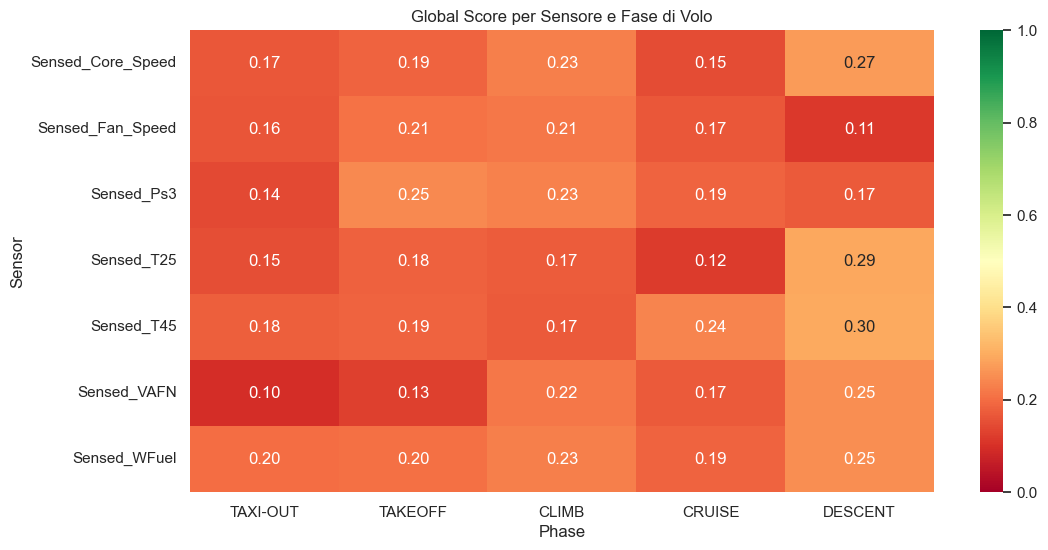


--- MIGLIOR COMBINAZIONE ---
Sensore: Sensed_T45
Fase: DESCENT
Score: 0.2967


In [4]:
# Impostazione tema
sns.set_theme(style="whitegrid")

# --- 1. DEFINIZIONE FUNZIONI ---

def get_aggregated_trajectories(df, sensor, phase):
    """
    Estrae le traiettorie per ogni motore per una specifica fase e sensore.
    """
    phase_data = df[df['Flight_Phase'] == phase].copy()
    if phase_data.empty: return []
    
    # Aggregazione per ciclo (media per ciclo per ridurre il rumore intra-volo)
    cycle_data = phase_data.groupby(['ESN', 'Cycles_Since_New'])[sensor].mean().reset_index()
    
    trajectories = []
    for esn in cycle_data['ESN'].unique():
        traj = cycle_data[cycle_data['ESN'] == esn].sort_values('Cycles_Since_New')[sensor].values
        # Filtro: traiettorie troppo corte non sono utili per trend/prognostics
        if len(traj) > 5:
            trajectories.append(traj)
            
    return trajectories

def calculate_metrics_robust(trajectories):
    """
    Calcola Monotonicity, Prognosability e Trendability gestendo errori e NaN.
    """
    if not trajectories or len(trajectories) < 2:
        return 0.0, 0.0, 0.0

    # --- A. MONOTONICITÀ ---
    mon_scores = []
    for traj in trajectories:
        diffs = np.diff(traj)
        if len(diffs) == 0: continue
        
        if np.all(diffs == 0):
            mon_scores.append(0.0)
            continue
            
        pos = np.sum(diffs > 0)
        neg = np.sum(diffs < 0)
        mon_scores.append(abs(pos - neg) / len(diffs))
    
    monotonicity = np.nanmean(mon_scores) if mon_scores else 0.0

    # --- B. PROGNOSABILITY ---
    try:
        final_values = [t[-1] for t in trajectories]
        ranges = [abs(t[-1] - t[0]) for t in trajectories]
        
        std_final = np.std(final_values)
        mean_range = np.mean(ranges)
        
        if mean_range < 1e-9: 
            prognosability = 0.0
        else:
            prognosability = np.exp(-std_final / mean_range)
    except:
        prognosability = 0.0

    # --- C. TRENDABILITY ---
    try:
        resampled_trajs = []
        common_len = 50
        x_common = np.linspace(0, 1, common_len)
        
        valid_trajs = 0
        for traj in trajectories:
            if np.std(traj) < 1e-9: # Skip segnali piatti
                resampled_trajs.append(np.zeros(common_len))
            else:
                x_old = np.linspace(0, 1, len(traj))
                f = interp1d(x_old, traj, kind='linear')
                resampled_trajs.append(f(x_common))
                valid_trajs += 1
        
        if valid_trajs < 2:
            trendability = 0.0
        else:
            R = np.corrcoef(resampled_trajs)
            R = np.nan_to_num(R, 0.0)
            mask = np.triu(np.ones_like(R, dtype=bool), k=1)
            corrs = np.abs(R[mask])
            trendability = np.mean(corrs) if len(corrs) > 0 else 0.0
    except:
        trendability = 0.0

    return float(np.nan_to_num(monotonicity)), float(np.nan_to_num(prognosability)), float(np.nan_to_num(trendability))

# --- 2. CALCOLO E CREAZIONE DATAFRAME RISULTATI ---

sensors_to_eval = [
    'Sensed_T45', 'Sensed_T25', 'Sensed_Ps3', 
    'Sensed_Fan_Speed', 'Sensed_Core_Speed', 'Sensed_WFuel', 'Sensed_VAFN'
]
phases = ['TAXI-OUT', 'TAKEOFF', 'CLIMB', 'CRUISE', 'DESCENT', 'LANDING', 'TAXI-IN']

results = []

print("Calcolo metriche in corso...")
for sensor in sensors_to_eval:
    # Verifica esistenza colonna
    if sensor not in df_segmented.columns: continue
            
    for phase in phases:
        trajs = get_aggregated_trajectories(df_segmented, sensor, phase)
            
        if len(trajs) > 0:
            mon, prog, trend = calculate_metrics_robust(trajs)
            score = (mon + prog + trend) / 3
                
            results.append({
                'Sensor': sensor,
                'Phase': phase,
                'Monotonicity': mon,
                'Prognosability': prog,
                'Trendability': trend, 
                'Global_Score': score
            })

# Creazione DataFrame di riepilogo
results_df = pd.DataFrame(results)

if not results_df.empty:
    # --- 4. VISUALIZZAZIONE ---
    phase_order = [p for p in phases if p in results_df['Phase'].unique()]
    pivot_score = results_df.pivot(index='Sensor', columns='Phase', values='Global_Score')
    pivot_score = pivot_score[phase_order]
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_score, annot=True, cmap='RdYlGn', fmt=".2f", vmin=0, vmax=1)
    plt.title("Global Score per Sensore e Fase di Volo")
    plt.show()

    # Stampa del miglior sensore/fase
    best_combo = results_df.loc[results_df['Global_Score'].idxmax()]
    print(f"\n--- MIGLIOR COMBINAZIONE ---")
    print(f"Sensore: {best_combo['Sensor']}")
    print(f"Fase: {best_combo['Phase']}")
    print(f"Score: {best_combo['Global_Score']:.4f}")

else:
    print("ERRORE: Nessun risultato calcolato. Controlla i dati di input.")

Per analizzare al meglio la Heatmap, si considerano come i target lasciano delle "impronte digitali" diverse sui sensori:

- **HPC Water-Wash & Shop Visit (breve termine)**: il compressore è sporco (fouling). Questo riduce il flusso d'aria e il rapporto di compressione. _Segnale_: calo di efficienza del compressore, recuperabile con il lavaggio.
   - Guardando la riga `Sensed_Ps3` si osserva un `Global_Score` di 0.25 in "TAKEOFF". La pressione di scarico del compressore quindi è un indicatore diretto della salute dell'HPC. Ciò potrebbe significare che al decollo, il compressore lavora al massimo rapporto di compressione. In questa fase l'erosione/sporco delle pale si fanno sentire di più e il motore fa fatica a comprimere l'aria.
   - Una strategia potrebbe essere costruire un indicatore basato sui **Residui di Ps3 durante il decollo**. Se il residuo scende (perdita di pressione) e poi risale improvvisamente, si individua un **Water-Wash**. Se si scende costantemente senza risalire, si individua un **HPC Shop Visit**.

- **HPT Shop Visit (evento termico/meccanico)**: la turbina è degradata. _Segnale_: la turbina estrae meno energia, quindi serve più carburante e temperature più alte per mantenere la stessa spinta.
   - Guardando la riga `Sensed_T45` si osserva un `Global_Score` di 0.30 in "DESCENT" e 0.24 in "CRUISE". Quindi, la temperatura tra le turbine è il proxy primario dell'efficienza della turbina. Il punteggio alto in discesa (0.30) indica che il segnale è molto pulito (basso rumore), ottimo per trend a lungo termine. Tuttavia, la degradazione termica avviene sotto sforzo.
   - Una strategia potrebbe essere la combinazione della stabilità della Discesa con l'intensità della Crociera. Un aumento progressivo e irreversibile del residuo T45 potrebbe essere la firma dell'usura HPT.

- **Arbitro globale --> `WFuel`**: il sensore ha punteggi solidi ovunque (~0.20-0.25), specialmente in "DESCENT" e "CLIMB". Se l'efficienza cala il computer del motore pompa più carburante per compensare. 
   - Questa feature non descrive cosa è rotto, ma che qualcosa è rotto, quindi potrebbe essere usato come _validatore_. Se il Ps3 è brutto ma WFuel è normale, potrebbe essere un sensore guasto. Se entrambi peggiorano, il guasto è reale.

In sintesi, la Heatmap mostra come la fase di "TAXI-OUT" (in generale Taxi) non sia informativa per la salute del motore, ma sono dominati dai movimenti della manetta. Quindi, può essere eliminata dal dataset.

In [5]:
# Eliminazione della colonna "TAXI-OUT" (e "TAXI-IN" + "LANDING" se presenti)
columns_to_drop = ['TAXI-OUT', 'TAXI-IN', 'LANDING']
if 'Flight_Phase' in df_segmented.columns:
    df_segmented = df_segmented[~df_segmented['Flight_Phase'].isin(columns_to_drop)]

# Salvataggio del DataFrame segmentato
output_filename = '../data/temp/01_training_data_segmented.csv'
df_segmented.to_csv(output_filename, index=False)
print(f"\nDataset segmentato salvato in: {output_filename}")


Dataset segmentato salvato in: ../data/temp/01_training_data_segmented.csv
